In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

In [2]:
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
MONTHS = ["oct23", "nov23", "dec23"]  # Add more months as you expand


In [3]:
monthly_token_data = {}

for month in MONTHS:
    files = glob.glob(f"{BASE_PATH}/{month}/*.csv")
    month_prices = {}
    month_volumes = {}

    for file in files:
        token = os.path.basename(file).replace(".csv", "")
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.lower()
            if 'close' not in df.columns or 'volume' not in df.columns:
                continue

            df = df.sort_values(by='timestamp').reset_index(drop=True)
            df['days_since_launch'] = df.index
            month_prices[token] = df[['days_since_launch', 'close']].set_index('days_since_launch').rename(columns={'close': token})
            month_volumes[token] = df[['days_since_launch', 'volume']].set_index('days_since_launch').rename(columns={'volume': token})
        except Exception as e:
            print(f"⚠️ Error in {token}: {e}")

    if month_prices and month_volumes:
        aligned_prices = pd.concat(month_prices.values(), axis=1, join='inner')
        aligned_volumes = pd.concat(month_volumes.values(), axis=1, join='inner')

        monthly_token_data[month] = {
            "prices": aligned_prices,
            "volumes": aligned_volumes
        }

        print(f"✅ Loaded {month}: {aligned_prices.shape[1]} tokens, {aligned_prices.shape[0]} days")
    else:
        print(f"❌ Skipped {month}: No valid token data found")


✅ Loaded oct23: 5 tokens, 369 days
✅ Loaded nov23: 5 tokens, 374 days
✅ Loaded dec23: 5 tokens, 275 days


📈 oct23: Final portfolio value = 222931.36
📈 nov23: Final portfolio value = 1286276.53
📈 dec23: Final portfolio value = 5998088.57


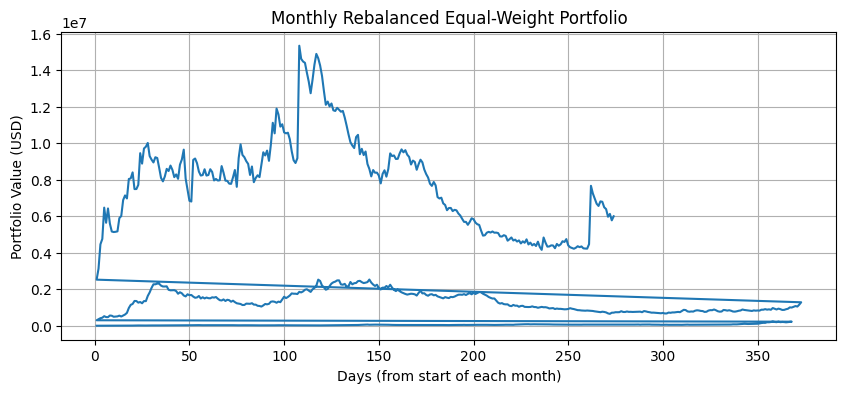

In [4]:
import numpy as np
import matplotlib.pyplot as plt

initial_capital = 1000  # Starting with $1000
portfolio_values = []  # Store cumulative portfolio values for each month
current_value = initial_capital

for month in MONTHS:
    data = monthly_token_data.get(month)
    if data is None:
        print(f"⏭️ Skipping {month} (no data)")
        continue

    prices = data["prices"]
    returns = prices.pct_change().dropna()

    # Equal weights
    n_tokens = returns.shape[1]
    weights = np.repeat(1 / n_tokens, n_tokens)

    # Daily portfolio return = dot product of weights and daily token returns
    portfolio_daily_return = returns @ weights

    # Cumulative value (starting from current_value)
    portfolio_cumulative = (1 + portfolio_daily_return).cumprod() * current_value

    # Store and update value
    portfolio_values.append(portfolio_cumulative)
    current_value = portfolio_cumulative.iloc[-1]

    print(f"📈 {month}: Final portfolio value = {current_value:.2f}")

# Combine all months into one series
total_portfolio = pd.concat(portfolio_values)
total_portfolio.plot(title="Monthly Rebalanced Equal-Weight Portfolio", figsize=(10, 4))
plt.ylabel("Portfolio Value (USD)")
plt.xlabel("Days (from start of each month)")
plt.grid(True)
plt.show()


In [5]:
for month in MONTHS:
    data = monthly_token_data.get(month)
    if data:
        tokens = data["prices"].columns.tolist()
        print(f"📅 {month}: {len(tokens)} tokens → {tokens}")


📅 oct23: 5 tokens → ['JOE', 'KIZUNA', 'HAY', 'TITANX', 'BIGTIME']
📅 nov23: 5 tokens → ['MUBI', 'GROK', 'FLIP', 'MEME', 'TURT']
📅 dec23: 5 tokens → ['WBRGE', 'DOVA', 'PEAS', 'POINTS', '1CAT']


### Fully Rebalancing Portfolio

In [6]:
prev_tokens = None

for month in MONTHS:
    data = monthly_token_data.get(month)
    if not data:
        continue

    tokens = set(data["prices"].columns)
    print(f"\n📅 {month}")

    if prev_tokens is not None:
        added = tokens - prev_tokens
        removed = prev_tokens - tokens

        print(f"➕ Added: {sorted(added)}")
        print(f"➖ Removed: {sorted(removed)}")
    else:
        print(f"🆕 Initial tokens: {sorted(tokens)}")

    prev_tokens = tokens



📅 oct23
🆕 Initial tokens: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']

📅 nov23
➕ Added: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']
➖ Removed: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']

📅 dec23
➕ Added: ['1CAT', 'DOVA', 'PEAS', 'POINTS', 'WBRGE']
➖ Removed: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']


### Partial Rebalancing Portfolio

In [7]:
portfolio = set()

for i, month in enumerate(MONTHS):
    data = monthly_token_data.get(month)
    if not data:
        print(f"❌ No data for {month}")
        continue

    month_tokens = set(data["prices"].columns)

    if i == 0:
        # For the first month, initialize portfolio from top 5 tokens by volume this month
        volumes = data["volumes"][list(month_tokens)]
        avg_volumes = volumes.mean(axis=0).sort_values(ascending=False)
        portfolio = set(avg_volumes.head(5).index)
        print(f"📅 {month} - Initial Portfolio: {sorted(portfolio)}")
    else:
        # For subsequent months, partial rebalancing

        # Combine current portfolio tokens + new tokens launched this month
        tokens_to_consider = portfolio.union(month_tokens)

        available_tokens = set(data["volumes"].columns)
        tokens_to_consider = tokens_to_consider.intersection(available_tokens)

        if not tokens_to_consider:
            print(f"❌ No valid tokens to consider for {month}")
            continue

        volumes = data["volumes"][list(tokens_to_consider)]
        avg_volumes = volumes.mean(axis=0).sort_values(ascending=False)

        # Pick top 5 by volume to form new portfolio
        new_portfolio = set(avg_volumes.head(5).index)

        added = new_portfolio - portfolio
        removed = portfolio - new_portfolio

        print(f"\n📅 {month}")
        print(f"➕ Added: {sorted(added)}")
        print(f"➖ Removed: {sorted(removed)}")

        portfolio = new_portfolio


📅 oct23 - Initial Portfolio: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']

📅 nov23
➕ Added: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']
➖ Removed: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']

📅 dec23
➕ Added: ['1CAT', 'DOVA', 'PEAS', 'POINTS', 'WBRGE']
➖ Removed: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']


In [8]:
portfolio = set()

for i, month in enumerate(MONTHS):
    data = monthly_token_data.get(month)
    if not data:
        print(f"❌ No data for {month}")
        continue

    month_tokens = set(data["prices"].columns)

    if i == 0:
        # First month: initialize portfolio with top 5 tokens by volume
        volumes = data["volumes"][list(month_tokens)]
        avg_volumes = volumes.mean(axis=0).sort_values(ascending=False)
        portfolio = set(avg_volumes.head(5).index)
        print(f"📅 {month} - Initial Portfolio: {sorted(portfolio)}")
    else:
        # Partial rebalancing:
        # Combine previous portfolio + new tokens from this month
        tokens_to_consider = portfolio.union(month_tokens)

        # Filter only tokens that have volume data in this month
        available_tokens = set(data["volumes"].columns)
        tokens_to_consider = tokens_to_consider.intersection(available_tokens)

        if not tokens_to_consider:
            print(f"❌ No valid tokens to consider for {month}")
            continue

        volumes = data["volumes"][list(tokens_to_consider)]
        avg_volumes = volumes.mean(axis=0).sort_values(ascending=False)

        # Pick top 5 tokens by volume to form new portfolio
        new_portfolio = set(avg_volumes.head(5).index)

        added = new_portfolio - portfolio
        removed = portfolio - new_portfolio

        print(f"\n📅 {month}")
        print(f"➕ Added: {sorted(added)}")
        print(f"➖ Removed: {sorted(removed)}")

        portfolio = new_portfolio


📅 oct23 - Initial Portfolio: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']

📅 nov23
➕ Added: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']
➖ Removed: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']

📅 dec23
➕ Added: ['1CAT', 'DOVA', 'PEAS', 'POINTS', 'WBRGE']
➖ Removed: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']


In [9]:
portfolio = set()  # Initialize portfolio before loop

for i, month in enumerate(MONTHS):
    data = monthly_token_data.get(month)
    if not data:
        print(f"❌ No data for {month}")
        continue

    month_tokens = set(data["prices"].columns)

    volumes = data["volumes"][list(month_tokens)].fillna(0)
    avg_volumes = volumes.mean(axis=0)
    avg_volumes = avg_volumes[avg_volumes > 0].sort_values(ascending=False)

    if i == 0:
        # First month: pick top 5 tokens by volume as initial portfolio
        portfolio = set(avg_volumes.head(5).index)
        print(f"📅 {month} - Initial Portfolio: {sorted(portfolio)}")
    else:
        tokens_to_consider = portfolio.union(month_tokens)
        available_tokens = set(data["volumes"].columns)
        tokens_to_consider = tokens_to_consider.intersection(available_tokens)

        if not tokens_to_consider:
            print(f"❌ No valid tokens to consider for {month}")
            continue

        volumes = data["volumes"][list(tokens_to_consider)].fillna(0)
        avg_volumes = volumes.mean(axis=0).sort_values(ascending=False)

        # Debug prints for old portfolio volumes available this month
        available_portfolio_tokens = [t for t in portfolio if t in avg_volumes.index]
        print(f"Old portfolio volumes (available tokens):\n{avg_volumes.loc[available_portfolio_tokens].sort_values(ascending=False)}")

        # Debug prints for new tokens volumes
        available_new_tokens = [t for t in month_tokens if t in avg_volumes.index]
        print(f"New month tokens volumes (available tokens):\n{avg_volumes.loc[available_new_tokens].sort_values(ascending=False)}")

        new_portfolio = set(avg_volumes.head(5).index)

        added = new_portfolio - portfolio
        removed = portfolio - new_portfolio

        print(f"\n📅 {month}")
        print(f"➕ Added: {sorted(added)}")
        print(f"➖ Removed: {sorted(removed)}")

        portfolio = new_portfolio


📅 oct23 - Initial Portfolio: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']
Old portfolio volumes (available tokens):
Series([], dtype: float64)
New month tokens volumes (available tokens):
TURT    1.056400e+44
MUBI    2.478843e+06
GROK    2.114450e+06
FLIP    8.168658e+05
MEME    1.340902e+05
dtype: float64

📅 nov23
➕ Added: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']
➖ Removed: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']
Old portfolio volumes (available tokens):
Series([], dtype: float64)
New month tokens volumes (available tokens):
1CAT      919530.652272
PEAS      646081.005790
DOVA      270649.805265
WBRGE     230003.071531
POINTS    136802.835666
dtype: float64

📅 dec23
➕ Added: ['1CAT', 'DOVA', 'PEAS', 'POINTS', 'WBRGE']
➖ Removed: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']


In [10]:
portfolio = set()

for i, month in enumerate(MONTHS):
    data = monthly_token_data.get(month)
    if not data:
        print(f"❌ No data for {month}")
        continue

    month_tokens = set(data["prices"].columns)

    volumes = data["volumes"].fillna(0)  # fill NaNs to avoid issues

    if i == 0:
        # Initial portfolio: top 5 tokens by average volume this month
        avg_volumes = volumes.mean(axis=0)
        avg_volumes = avg_volumes[avg_volumes > 0].sort_values(ascending=False)
        portfolio = set(avg_volumes.head(5).index)
        print(f"📅 {month} - Initial Portfolio: {sorted(portfolio)}")
    else:
        # Partial rebalance:
        # Combine old portfolio with new tokens this month
        tokens_to_consider = portfolio.union(month_tokens)

        # Only consider tokens that have volume data this month
        tokens_to_consider = tokens_to_consider.intersection(set(volumes.columns))

        if not tokens_to_consider:
            print(f"❌ No valid tokens to consider for {month}")
            continue

        avg_volumes = volumes[list(tokens_to_consider)].mean(axis=0)
        avg_volumes = avg_volumes[avg_volumes > 0].sort_values(ascending=False)

        # Pick top 5 tokens by volume from combined set
        new_portfolio = set(avg_volumes.head(5).index)

        added = new_portfolio - portfolio
        removed = portfolio - new_portfolio

        print(f"\n📅 {month} - Partial Rebalance")
        print(f"➕ Added: {sorted(added)}")
        print(f"➖ Removed: {sorted(removed)}")

        portfolio = new_portfolio

    print(f"Current Portfolio after {month}: {sorted(portfolio)}")


📅 oct23 - Initial Portfolio: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']
Current Portfolio after oct23: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']

📅 nov23 - Partial Rebalance
➕ Added: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']
➖ Removed: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']
Current Portfolio after nov23: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']

📅 dec23 - Partial Rebalance
➕ Added: ['1CAT', 'DOVA', 'PEAS', 'POINTS', 'WBRGE']
➖ Removed: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']
Current Portfolio after dec23: ['1CAT', 'DOVA', 'PEAS', 'POINTS', 'WBRGE']


### Avoiding Lookahead Bias

In [11]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

In [12]:
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
MONTHS = ["oct23", "nov23", "dec23"]  # Add more months as you expand

In [13]:
monthly_token_data = {}

for month in MONTHS:
    files = glob.glob(f"{BASE_PATH}/{month}/*.csv")
    month_prices = {}
    month_volumes = {}

    for file in files:
        token = os.path.basename(file).replace(".csv", "")
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.lower()
            if 'close' not in df.columns or 'volume' not in df.columns:
                continue

            df = df.sort_values(by='timestamp').reset_index(drop=True)
            df['days_since_launch'] = df.index
            month_prices[token] = df[['days_since_launch', 'close']].set_index('days_since_launch').rename(columns={'close': token})
            month_volumes[token] = df[['days_since_launch', 'volume']].set_index('days_since_launch').rename(columns={'volume': token})
        except Exception as e:
            print(f"⚠️ Error in {token}: {e}")

    if month_prices and month_volumes:
        aligned_prices = pd.concat(month_prices.values(), axis=1, join='inner')
        aligned_volumes = pd.concat(month_volumes.values(), axis=1, join='inner')

        monthly_token_data[month] = {
            "prices": aligned_prices,
            "volumes": aligned_volumes
        }

        print(f"✅ Loaded {month}: {aligned_prices.shape[1]} tokens, {aligned_prices.shape[0]} days")
    else:
        print(f"❌ Skipped {month}: No valid token data found")


✅ Loaded oct23: 5 tokens, 369 days
✅ Loaded nov23: 5 tokens, 374 days
✅ Loaded dec23: 5 tokens, 275 days



📦 Loaded 15 unique tokens total.

📅 Window 1: Launch = days 0-29, Hold = 30-59
Top 5 tokens launched in this window: ['TURT', 'BIGTIME', 'GROK', 'MUBI', '1CAT']

📅 Window 2: Launch = days 30-59, Hold = 60-89
Top 5 tokens launched in this window: ['MUBI', 'GROK', 'TITANX', 'TURT', 'PEAS']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_36989/3375787201.py:90: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


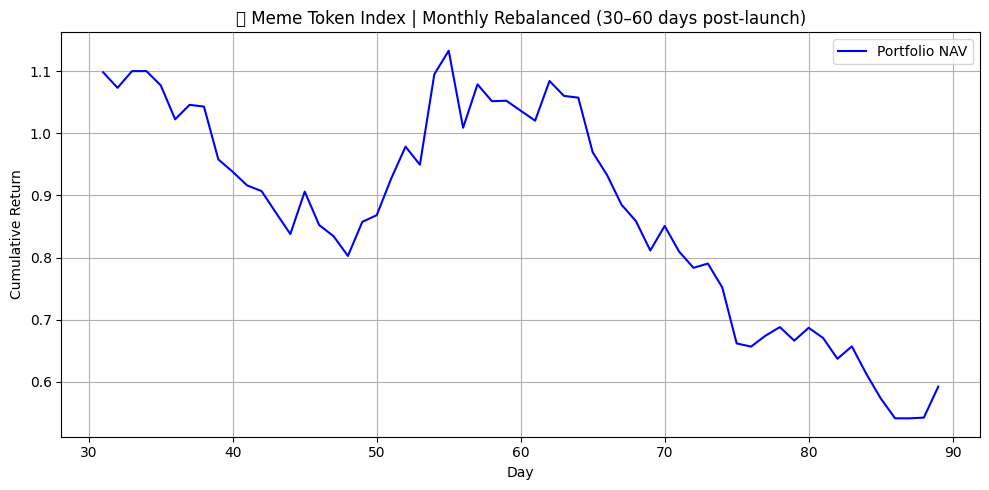

In [14]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
ALL_MONTHS = ["oct23", "nov23", "dec23"]
MONTH_RANGES = [(0, 29), (30, 59), (60, 89)] 

# Step 1: Load ALL tokens from ALL folders
all_token_data = {}
for month in ALL_MONTHS:
    files = glob.glob(f"{BASE_PATH}/{month}/*.csv")
    for file in files:
        token = os.path.basename(file).replace(".csv", "")
        if token in all_token_data:
            continue  # avoid duplicate
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.lower()
            if 'close' not in df.columns or 'volume' not in df.columns:
                continue
            df = df.sort_values(by='timestamp').reset_index(drop=True)
            df['days_since_launch'] = df.index
            all_token_data[token] = df
        except Exception as e:
            print(f"⚠️ Error loading {token}: {e}")

print(f"\n📦 Loaded {len(all_token_data)} unique tokens total.")

# Step 2: Loop over each month window, rebalance
portfolio_returns = []

for i, (launch_start, launch_end) in enumerate(MONTH_RANGES[:-1]):
    hold_start, hold_end = MONTH_RANGES[i + 1]
    print(f"\n📅 Window {i+1}: Launch = days {launch_start}-{launch_end}, Hold = {hold_start}-{hold_end}")

    # 2A: Pick tokens launched in this range
    candidates = []
    for token, df in all_token_data.items():
        if df['days_since_launch'].min() <= launch_start and df['days_since_launch'].max() >= hold_end:
            df_launch = df[(df['days_since_launch'] >= launch_start) & (df['days_since_launch'] <= launch_end)]
            if len(df_launch) < 10:
                continue
            total_vol = df_launch['volume'].sum()
            candidates.append((token, total_vol))

    if len(candidates) < 5:
        print("⚠️ Not enough tokens launched in this window.")
        continue

    # 2B: Sort by volume and take top 5
    candidates.sort(key=lambda x: x[1], reverse=True)
    top_tokens = [t[0] for t in candidates[:5]]
    print(f"Top 5 tokens launched in this window: {top_tokens}")

    # 2C: Get price data from day 30–59
    price_data = []
    for token in top_tokens:
        df = all_token_data[token]
        df_hold = df[(df['days_since_launch'] >= hold_start) & (df['days_since_launch'] <= hold_end)]
        if df_hold.shape[0] < 2:
            print(f"❌ Skipping {token}, insufficient hold period data.")
            continue
        price_series = df_hold[['days_since_launch', 'close']].set_index('days_since_launch').rename(columns={'close': token})
        price_data.append(price_series)

    if len(price_data) < 2:
        print("⚠️ Not enough valid price series for portfolio.")
        continue

    combined_prices = pd.concat(price_data, axis=1).ffill().bfill()
    daily_returns = combined_prices.pct_change().dropna()
    equal_weighted = daily_returns.mean(axis=1)
    portfolio_returns.append(equal_weighted)

# Step 3: Plot cumulative NAV
if portfolio_returns:
    nav = pd.concat(portfolio_returns)
    cumulative_nav = (1 + nav).cumprod()

    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_nav, label="Portfolio NAV", color="blue")
    plt.title("📈 Meme Token Index | Monthly Rebalanced (30–60 days post-launch)")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("🚫 No valid portfolio returns to plot.")


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_36989/2265092398.py:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


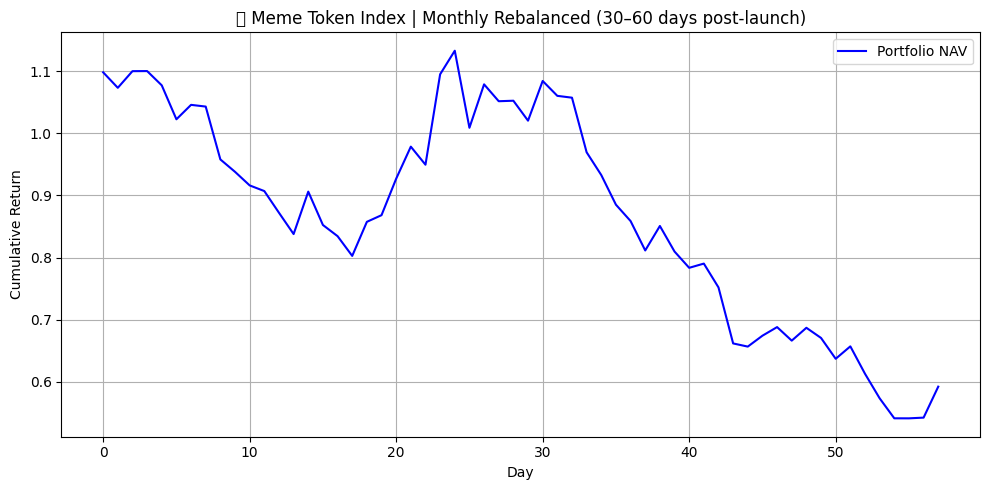


📊 Performance Metrics:
Total Return     : -40.77%
Annualized Return: -96.30%
Daily Volatility : 5.29%
Sharpe Ratio     : -2.76
Max Drawdown     : -52.22%

📅 Window-wise Returns:
  Window  Days Return % Sharpe
0      1    29    5.25%   1.11
1      2    29  -43.72%  -7.65


In [15]:
# Step 3: Combine returns and calculate metrics
if portfolio_returns:
    nav = pd.concat(portfolio_returns, ignore_index=True)
    cumulative_nav = (1 + nav).cumprod()
    
    # Plot NAV
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_nav, label="Portfolio NAV", color="blue")
    plt.title("📈 Meme Token Index | Monthly Rebalanced (30–60 days post-launch)")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Metrics
    total_return = cumulative_nav.iloc[-1] - 1
    annualized_return = (1 + total_return) ** (365 / len(cumulative_nav)) - 1
    daily_vol = nav.std()
    sharpe_ratio = (nav.mean() / nav.std()) * np.sqrt(365)
    max_dd = (cumulative_nav / cumulative_nav.cummax() - 1).min()

    print("\n📊 Performance Metrics:")
    print(f"Total Return     : {total_return:.2%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Daily Volatility : {daily_vol:.2%}")
    print(f"Sharpe Ratio     : {sharpe_ratio:.2f}")
    print(f"Max Drawdown     : {max_dd:.2%}")

    # Optional: Show PnL per rebalancing window
    print("\n📅 Window-wise Returns:")
    nav_table = []
    for idx, ret in enumerate(portfolio_returns):
        nav_local = (1 + ret).cumprod()
        ret_pct = nav_local.iloc[-1] - 1
        nav_table.append({
            "Window": f"{idx+1}",
            "Days": len(nav_local),
            "Return %": f"{ret_pct * 100:.2f}%",
            "Sharpe": f"{(ret.mean() / ret.std()) * np.sqrt(365):.2f}" if ret.std() != 0 else "N/A"
        })
    print(pd.DataFrame(nav_table))

else:
    print("🚫 No valid portfolio returns to analyze.")


### Comparing Loookahead Bias vs Non-Lookahead Bias

1. October-2023

🔍 Loading files...
📦 Loaded 5 tokens.
📊 Top tokens by volume in oct23: ['BIGTIME', 'HAY', 'JOE', 'TITANX', 'KIZUNA']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['BIGTIME', 'HAY', 'JOE', 'TITANX', 'KIZUNA']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–59): ['BIGTIME', 'HAY', 'JOE', 'TITANX', 'KIZUNA']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_36989/3965871493.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


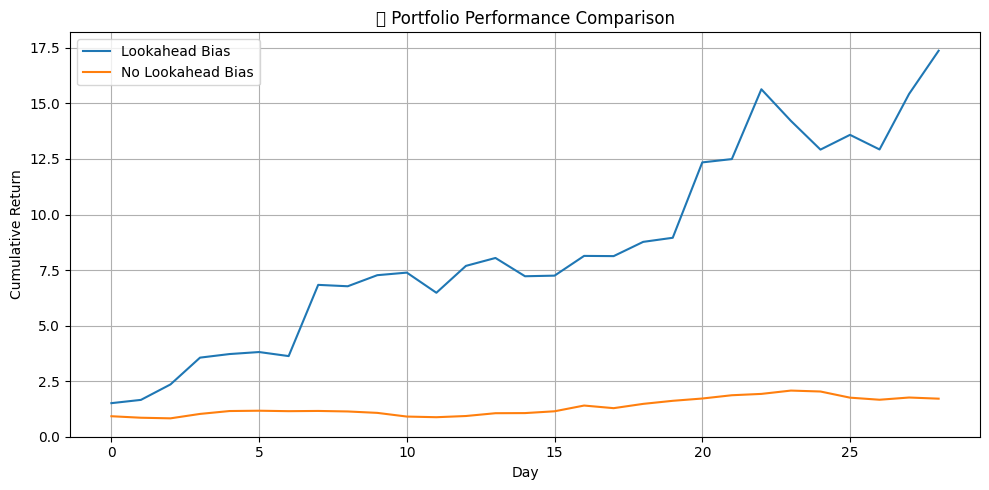


📊 Lookahead Bias Portfolio:
        Total Return: 1637.09%
   Annualized Return: 402412834830447488.00%
        Sharpe Ratio: 10.31
        Max Drawdown: -17.37%

📊 No Lookahead Bias Portfolio:
        Total Return: 71.18%
   Annualized Return: 86635.11%
        Sharpe Ratio: 4.55
        Max Drawdown: -24.98%


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 59
MONTH = "oct23" 

# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")

# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")

# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")

# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics

# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")

# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")


2. November 2023

🔍 Loading files...
📦 Loaded 5 tokens.
📊 Top tokens by volume in nov23: ['TURT', 'GROK', 'MUBI', 'FLIP', 'MEME']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['TURT', 'GROK', 'MUBI', 'FLIP', 'MEME']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–59): ['TURT', 'GROK', 'MUBI', 'FLIP', 'MEME']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_36989/3527640146.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


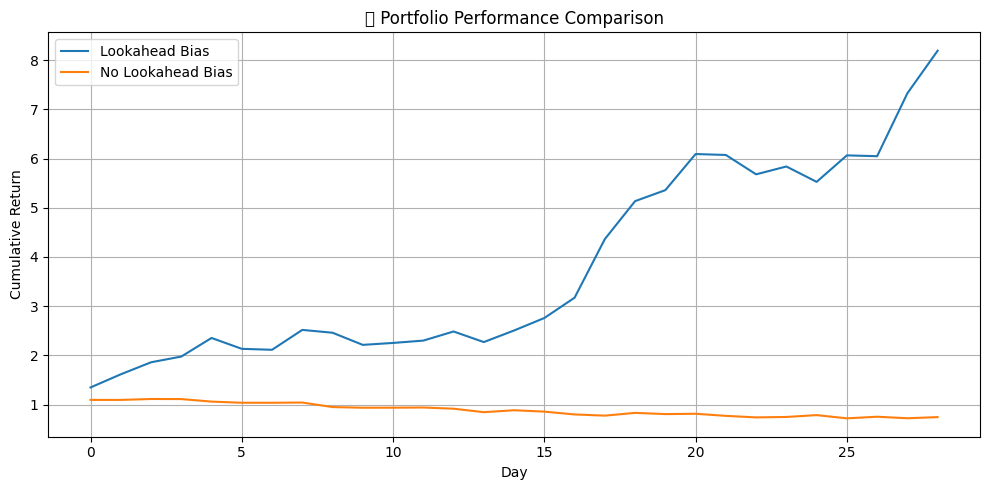


📊 Lookahead Bias Portfolio:
        Total Return: 719.27%
   Annualized Return: 31375758011337.79%
        Sharpe Ratio: 12.83
        Max Drawdown: -12.09%

📊 No Lookahead Bias Portfolio:
        Total Return: -25.50%
   Annualized Return: -97.54%
        Sharpe Ratio: -3.83
        Max Drawdown: -35.33%


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 59
MONTH = "nov23"  

# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")

# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")

# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")

# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics

# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")

# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")


3. December-2023

🔍 Loading files...
📦 Loaded 5 tokens.
📊 Top tokens by volume in dec23: ['1CAT', 'PEAS', 'DOVA', 'WBRGE', 'POINTS']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['1CAT', 'PEAS', 'DOVA', 'WBRGE', 'POINTS']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–59): ['1CAT', 'PEAS', 'DOVA', 'WBRGE', 'POINTS']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_36989/1887767906.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


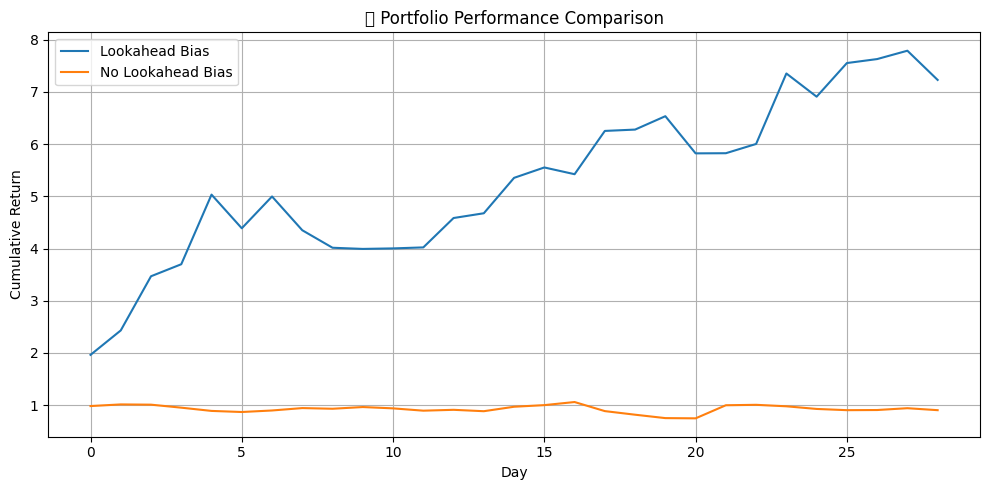


📊 Lookahead Bias Portfolio:
        Total Return: 622.79%
   Annualized Return: 6481934595282.96%
        Sharpe Ratio: 7.72
        Max Drawdown: -20.66%

📊 No Lookahead Bias Portfolio:
        Total Return: -9.59%
   Annualized Return: -71.87%
        Sharpe Ratio: -0.11
        Max Drawdown: -29.46%


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 59
MONTH = "dec23"  

# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")

# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")

# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")

# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics

# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")

# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")


4. January-2024

/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_36989/3495494230.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


🔍 Loading files...
📦 Loaded 5 tokens.
📊 Top tokens by volume in jan24: ['PORK', 'SAVM', 'ONDO', 'wBAI', 'ALT']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['PORK', 'SAVM', 'ONDO', 'wBAI', 'ALT']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–59): ['PORK', 'SAVM', 'ONDO', 'wBAI', 'ALT']


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


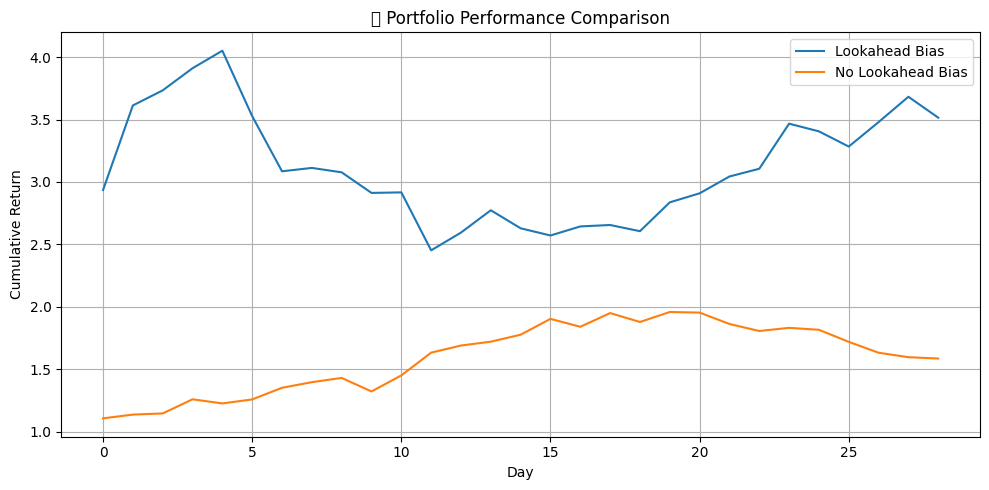


📊 Lookahead Bias Portfolio:
        Total Return: 251.47%
   Annualized Return: 742535026.29%
        Sharpe Ratio: 3.96
        Max Drawdown: -39.47%

📊 No Lookahead Bias Portfolio:
        Total Return: 58.55%
   Annualized Return: 32966.23%
        Sharpe Ratio: 6.29
        Max Drawdown: -19.04%


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 59
MONTH = "jan24"  

# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")

# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")

# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")

# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics

# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")

# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")


5. February-2024

🔍 Loading files...
📦 Loaded 5 tokens.
📊 Top tokens by volume in feb24: ['MINER', 'PANDORA', 'MAVIA', 'SORA', 'MNRCH']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['MINER', 'PANDORA', 'MAVIA', 'SORA', 'MNRCH']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–59): ['MINER', 'PANDORA', 'MAVIA', 'SORA', 'MNRCH']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_36989/2459575261.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


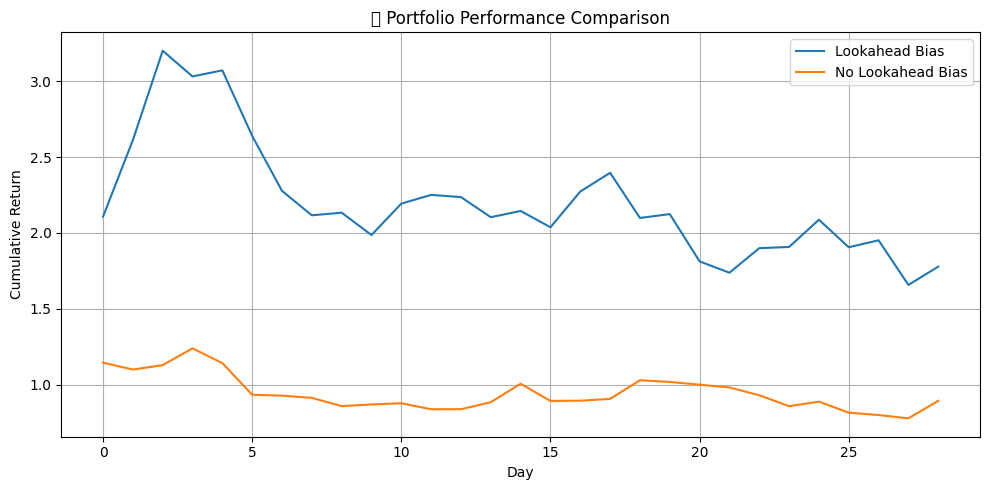


📊 Lookahead Bias Portfolio:
        Total Return: 77.74%
   Annualized Return: 139141.72%
        Sharpe Ratio: 3.10
        Max Drawdown: -48.23%

📊 No Lookahead Bias Portfolio:
        Total Return: -10.72%
   Annualized Return: -76.00%
        Sharpe Ratio: -0.23
        Max Drawdown: -37.26%


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 59
MONTH = "feb24"  

# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")

# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")

# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")

# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics

# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")

# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")


6. March 2024

🔍 Loading files...
📦 Loaded 5 tokens.
📊 Top tokens by volume in mar24: ['BVM', 'DEAI', 'GNUS', 'SHFL', 'PORTAL']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['BVM', 'DEAI', 'GNUS', 'SHFL', 'PORTAL']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–59): ['BVM', 'DEAI', 'GNUS', 'SHFL', 'PORTAL']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_60686/4187919846.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


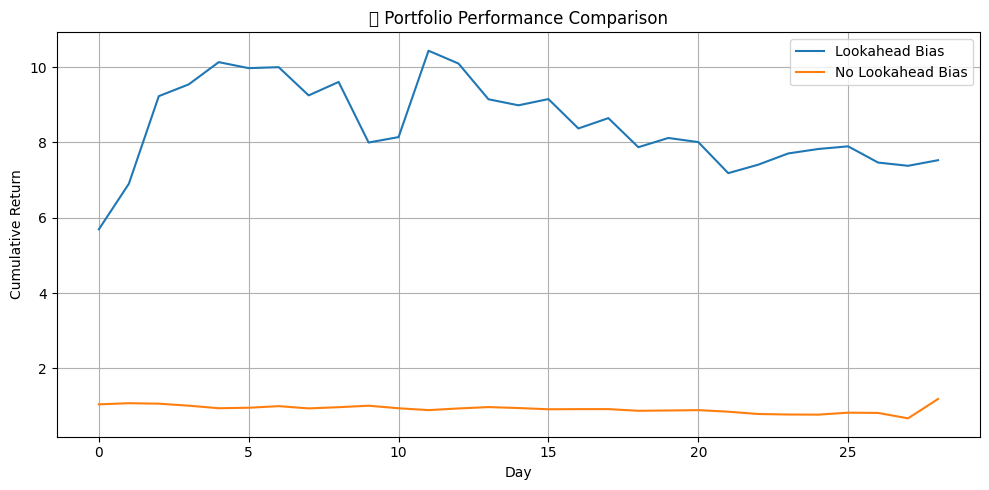


📊 Lookahead Bias Portfolio:
        Total Return: 652.71%
   Annualized Return: 10800494779616.99%
        Sharpe Ratio: 3.85
        Max Drawdown: -31.16%

📊 No Lookahead Bias Portfolio:
        Total Return: 18.52%
   Annualized Return: 748.53%
        Sharpe Ratio: 1.75
        Max Drawdown: -37.46%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 59
MONTH = "mar24"  

# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")

# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")

# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")

# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics

# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")

# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")


7. April 2024

🔍 Loading files...
📦 Loaded 5 tokens.
📊 Top tokens by volume in apr24: ['ENA', 'UDW', 'RUNIX', 'RIVUS', 'OLM']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['ENA', 'UDW', 'RUNIX', 'RIVUS', 'OLM']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–59): ['ENA', 'UDW', 'RUNIX', 'RIVUS', 'OLM']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_82348/3161571801.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


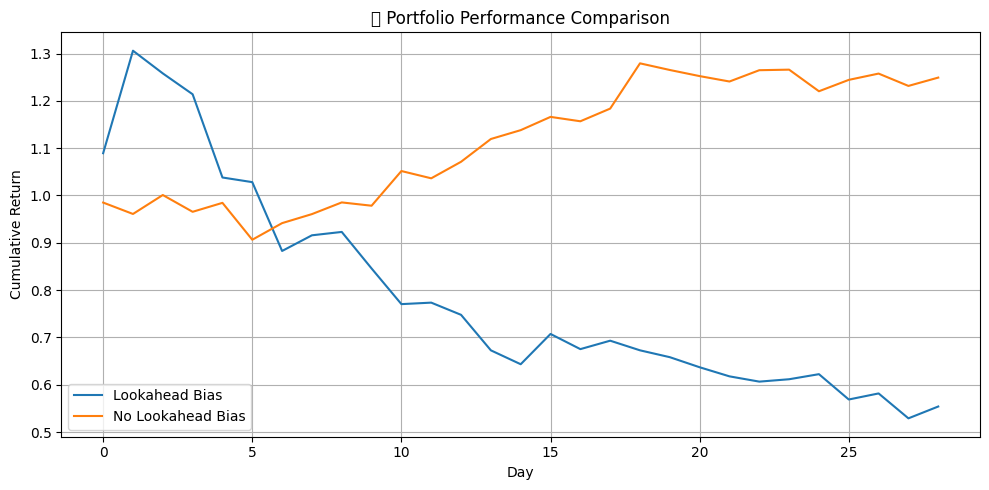


📊 Lookahead Bias Portfolio:
        Total Return: -44.61%
   Annualized Return: -99.94%
        Sharpe Ratio: -4.66
        Max Drawdown: -59.50%

📊 No Lookahead Bias Portfolio:
        Total Return: 24.92%
   Annualized Return: 1545.30%
        Sharpe Ratio: 4.71
        Max Drawdown: -9.45%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 59
MONTH = "apr24"  

# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")

# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")

# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")

# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics

# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")

# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")


8. May 2024

🔍 Loading files...
📦 Loaded 5 tokens.
📊 Top tokens by volume in may24: ['MAGA', 'PEW', 'wQUIL', 'RETIK', 'EAI']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['MAGA', 'PEW', 'wQUIL', 'RETIK', 'EAI']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–59): ['MAGA', 'PEW', 'wQUIL', 'RETIK', 'EAI']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_4394/4279524448.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


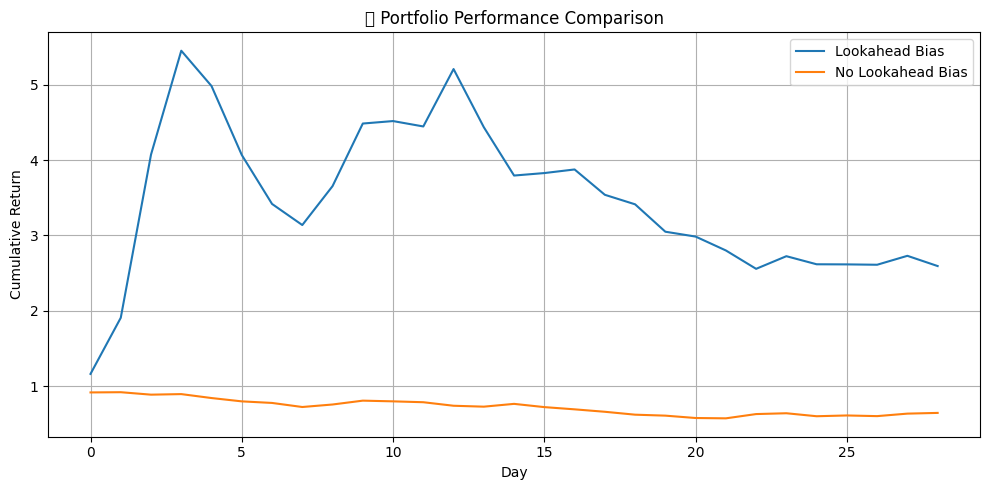


📊 Lookahead Bias Portfolio:
        Total Return: 159.47%
   Annualized Return: 16288356.34%
        Sharpe Ratio: 4.11
        Max Drawdown: -53.05%

📊 No Lookahead Bias Portfolio:
        Total Return: -35.14%
   Annualized Return: -99.57%
        Sharpe Ratio: -5.81
        Max Drawdown: -37.53%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 59
MONTH = "may24"  

# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")

# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")

# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")

# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics

# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")

# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")


9. June 2024

🔍 Loading files...
📦 Loaded 5 tokens.
📊 Top tokens by volume in jun24: ['RCH', 'PEIPEI', 'ATH', 'SHOG', 'GURU']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['RCH', 'PEIPEI', 'ATH', 'SHOG', 'GURU']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–59): ['RCH', 'PEIPEI', 'ATH', 'SHOG', 'GURU']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_27376/1282000230.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


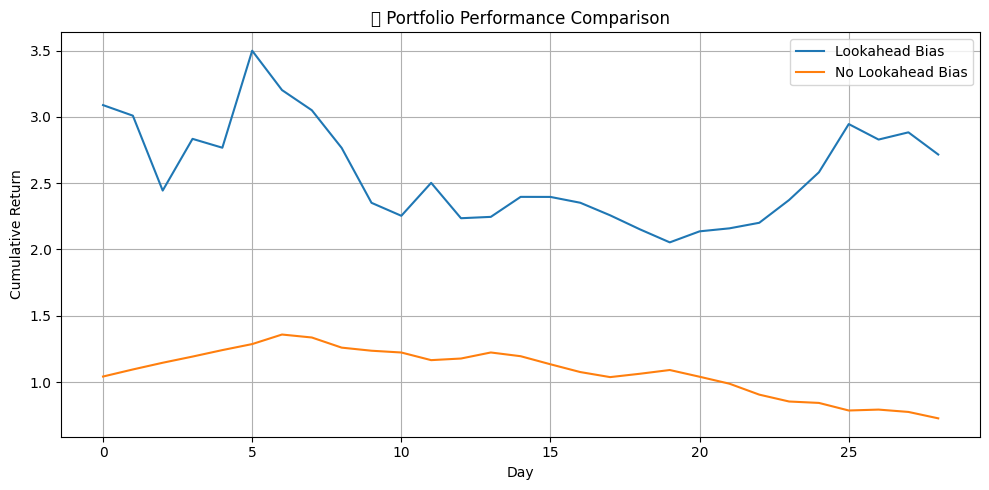


📊 Lookahead Bias Portfolio:
        Total Return: 171.61%
   Annualized Return: 28952780.38%
        Sharpe Ratio: 3.44
        Max Drawdown: -41.31%

📊 No Lookahead Bias Portfolio:
        Total Return: -27.35%
   Annualized Return: -98.21%
        Sharpe Ratio: -4.47
        Max Drawdown: -46.53%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 59
MONTH = "jun24"  

# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")

# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")

# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")

# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics

# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")

# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")


10. July 2024

🔍 Loading files...
📦 Loaded 5 tokens.
📊 Top tokens by volume in jul24: ['DINERO', 'FIGHT', 'NEIRO', 'MAPE', 'MOYA']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['DINERO', 'FIGHT', 'NEIRO', 'MAPE', 'MOYA']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–59): ['DINERO', 'FIGHT', 'NEIRO', 'MAPE', 'MOYA']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_51505/2630751822.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


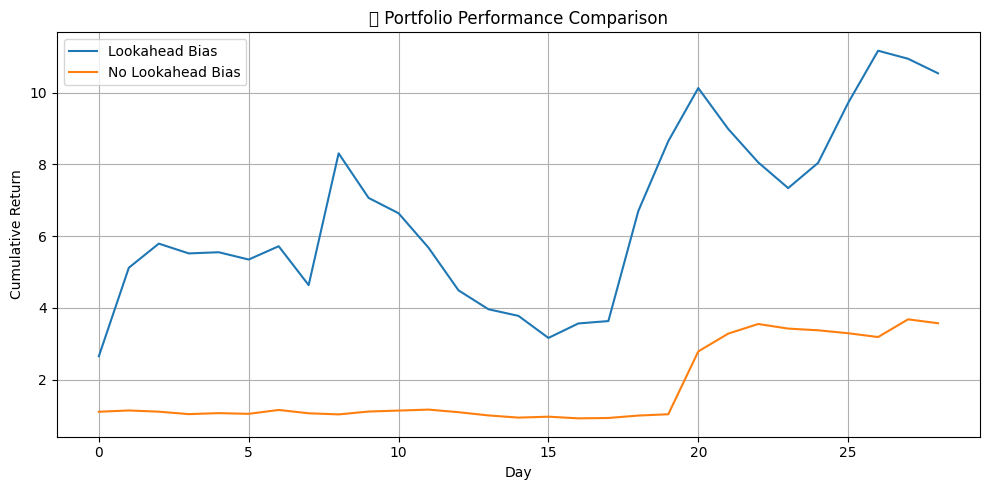


📊 Lookahead Bias Portfolio:
        Total Return: 954.33%
   Annualized Return: 750541997553381.50%
        Sharpe Ratio: 6.28
        Max Drawdown: -61.94%

📊 No Lookahead Bias Portfolio:
        Total Return: 257.21%
   Annualized Return: 910512037.48%
        Sharpe Ratio: 4.20
        Max Drawdown: -20.93%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 59
MONTH = "jul24"  

# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")

# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")

# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")

# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics

# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")

# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")


11. August 2024

🔍 Loading files...
📦 Loaded 5 tokens.
📊 Top tokens by volume in aug24: ['FUKU', 'KOIN', 'SATO', 'BERRY', 'WAI']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['FUKU', 'KOIN', 'SATO', 'BERRY', 'WAI']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–59): ['FUKU', 'KOIN', 'SATO', 'BERRY', 'WAI']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_5671/2278836099.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


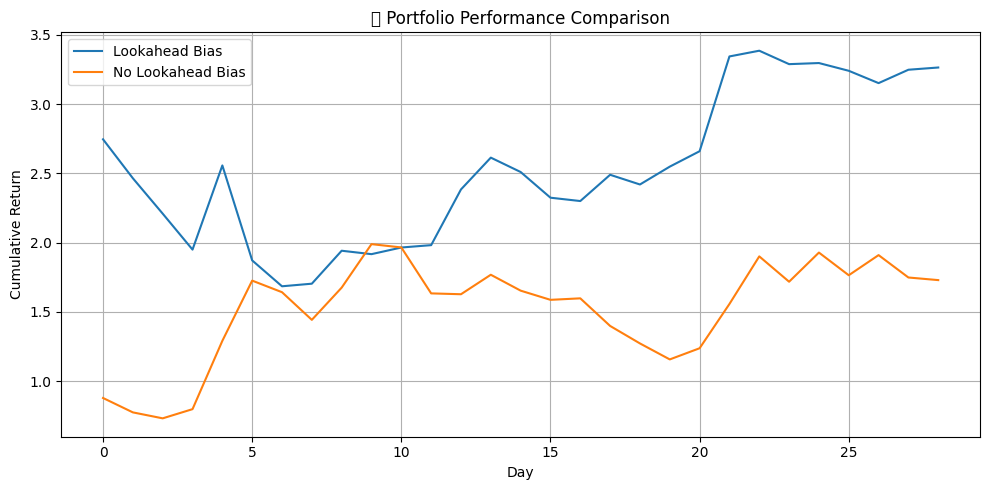


📊 Lookahead Bias Portfolio:
        Total Return: 226.47%
   Annualized Return: 293325391.62%
        Sharpe Ratio: 4.05
        Max Drawdown: -38.64%

📊 No Lookahead Bias Portfolio:
        Total Return: 72.98%
   Annualized Return: 98891.35%
        Sharpe Ratio: 3.47
        Max Drawdown: -41.83%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 59
MONTH = "aug24" 

# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")

# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")

# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")

# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics

# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")

# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")
